## 4.5 WGAN-GP
WGAN-GP是对WGAN的一种改进，它使用了一种称为梯度惩罚（Gradient Penalty）的技术来替代WGAN中的权重剪裁。其主要思想是通过对判别器的梯度进行惩罚，来达到与权重剪裁相同的效果，同时避免了权重剪裁可能会出现的一些问题。
除了梯度惩罚机制之外，WGAN-GP中的判别器没有使用批标准化（Batch Normalization）层。这是因为在批标准化中，每个小批量的输入都会被标准化，并且在训练过程中会计算均值和方差。然而，在WGAN-GP中，对于每个小批量的输入都是从真实数据和生成数据中随机采样得到的。因此，不同的批次之间的数据分布可能会有很大的差异，这会导致批标准化无法起到有效的归一化作用。
相比于WGAN，WGAN-GP可以更好地应用于图像处理、自然语言处理等领域，具有更强的鲁棒性、可靠性和稳定性。

### WGAN对GAN的改进，可归结为以下4点：  
- 判别器最后一层去掉sigmoid
- 生成器和判别器的loss不取log
- 每次更新判别器的参数之后把它们的绝对值截断到不超过一个固定常数c
- 不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp，SGD也行。


In [1]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from torchvision import transforms
from torchvision.utils import save_image

%matplotlib inline

In [15]:
# 设备配置
#torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行，这里假设使用序号为1的这块GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 定义一些超参数
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 100
batch_size = 100
# Loss weight for gradient penalty
lambda_gp = 10
sample_dir = 'wgangp_samples'

# 在当前目录，创建不存在的目录gan_samples
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [16]:
# Image processing
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../data',train=True,transform=trans,download=False)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,batch_size=batch_size, shuffle=True)

## 定义判别器的梯度惩罚函数

In [17]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available()  else torch.FloatTensor

def compute_gradient_penalty(D, real_samples, fake_samples):
    """计算WGAN-GP的梯度惩罚损失"""
    # 真实样本和假样本之间插值的随机权重项
    #alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    alpha = Tensor(np.random.random((real_samples.size(0), 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Tensor(real_samples.shape[0], 1).fill_(1.0)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## 判别器
获取数据，导入模块的过程基本与VAE的类似，这里不再展开来说。
定义判别器网络结构，这里使用LeakyReLU作为激活函数，经过两个全连接层，输出一个节点，不使用sigmoid激活函数，作为分布函数。
此外，考虑到不使用批正则化，因同批次的正则化会是创建相关性，从而导致梯度惩罚损失的有效性降低。

In [18]:
# 构建判断器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2,inplace=True),
    nn.Linear(hidden_size, 1))
    ##nn.Sigmoid())

## 生成器
GAN的生成器与VAE的生成器类似，不同的是GAN的输出为nn.tanh，它可以使数据分布在[-1,1]之间。其输入是潜在空间的向量z，输出维度与真图像的维度相同。

In [19]:
# 构建生成器，这个相当于AVE中的解码器 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.BatchNorm1d(hidden_size, 0.8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(hidden_size, hidden_size),
    nn.BatchNorm1d(hidden_size, 0.8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

## 定义损失函数，优化器等

In [20]:
# 把判别器和生成器迁移到GPU上
D = D.to(device)
G = G.to(device)

# 定义判别器的损失函数交叉熵及优化器
criterion = nn.BCELoss()
#d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
#g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
#d_optimizer = torch.optim.RMSprop(D.parameters(), lr=0.00002)
#g_optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00002)
g_optimizer= torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer= torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

#Clamp函数x限制在区间[min, max]内
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# 开始训练
total_step = len(data_loader)


## 训练模型
把判别器与生成器组合成一个完整模型，并对该模型进行训练。

In [21]:
for epoch in range(num_epochs):
    D_loss_list, G_loss_list = [], []
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      训练判别器                                    #
        # ================================================================== #

        # 定义判断器对真图片的损失函数
        outputs_r = D(images)
        #d_loss_real = criterion(outputs_r, real_labels)
        real_score = outputs_r
        
        # 定义判别器对假图片（即由潜在空间点生成的图片）的损失函数
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs_f = D(fake_images)
        #d_loss_fake = criterion(outputs_f, fake_labels)
        fake_score = outputs_f        
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(D, images.detach(), fake_images.detach())
        # Adversarial loss
        d_loss = -torch.mean(outputs_r) + torch.mean(outputs_f) + lambda_gp * gradient_penalty
        # 得到判别器总的损失函数
        #d_loss = d_loss_real + d_loss_fake
        #d_loss=-torch.mean(outputs_r) + torch.mean(outputs_f)
        
        
        D_loss_list.append(d_loss.item())
        
        # 对生成器、判别器的梯度清零        
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        #对判别器的权重进行截取
        #for p in D.parameters():    
        #    p.detach().clamp_(-0.01, 0.01)    
        # Train the generator every n_critic iterations
        if i % 5 == 0:
        
        # ================================================================== #
        #                        训练生成器                                  #
        # ================================================================== #

        # 定义生成器对假图片的损失函数，这里我们要求
        #判别器生成的图片越来越像真图片，故损失函数中
        #的标签改为真图片的标签，即希望生成的假图片，
        #越来越靠近真图片
            z = torch.randn(batch_size, latent_size).to(device)
            fake_images = G(z)
            outputs = D(fake_images)
        
        
            #g_loss = criterion(outputs, real_labels)
            g_loss=-torch.mean(outputs)
            G_loss_list.append(g_loss.item())
            # 对生成器、判别器的梯度清零
            #进行反向传播及运行生成器的优化器
            reset_grad()
            g_loss.backward()
            g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # 保存真图片
    if (epoch+1)%10 == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # 保存假图片
    if (epoch+1)%10 == 0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 保存模型
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [0/100], Step [200/600], d_loss: -22.6053, g_loss: -11.1137, D(x): 40.78, D(G(z)): 11.61
Epoch [0/100], Step [400/600], d_loss: -10.4544, g_loss: -19.0384, D(x): 31.44, D(G(z)): 19.18
Epoch [0/100], Step [600/600], d_loss: -4.5844, g_loss: -20.3423, D(x): 25.31, D(G(z)): 20.30
Epoch [1/100], Step [200/600], d_loss: -2.7393, g_loss: -19.7487, D(x): 22.66, D(G(z)): 19.79
Epoch [1/100], Step [400/600], d_loss: -1.8737, g_loss: -18.2720, D(x): 20.47, D(G(z)): 18.48
Epoch [1/100], Step [600/600], d_loss: -4.0259, g_loss: -8.7031, D(x): 12.69, D(G(z)): 8.18
Epoch [2/100], Step [200/600], d_loss: -4.4046, g_loss: -7.7112, D(x): 12.75, D(G(z)): 7.75
Epoch [2/100], Step [400/600], d_loss: -5.0149, g_loss: -7.3216, D(x): 13.07, D(G(z)): 7.41
Epoch [2/100], Step [600/600], d_loss: -4.3847, g_loss: -8.0587, D(x): 12.70, D(G(z)): 7.81
Epoch [3/100], Step [200/600], d_loss: -4.7935, g_loss: -7.0087, D(x): 11.70, D(G(z)): 6.44
Epoch [3/100], Step [400/600], d_loss: -4.1157, g_loss: -6.0308, D(x

Epoch [30/100], Step [200/600], d_loss: -3.3837, g_loss: -1.7032, D(x): 5.63, D(G(z)): 1.94
Epoch [30/100], Step [400/600], d_loss: -3.4054, g_loss: -2.4122, D(x): 5.81, D(G(z)): 2.10
Epoch [30/100], Step [600/600], d_loss: -3.1457, g_loss: -1.3915, D(x): 5.55, D(G(z)): 2.06
Epoch [31/100], Step [200/600], d_loss: -3.3113, g_loss: -2.0234, D(x): 5.90, D(G(z)): 2.28
Epoch [31/100], Step [400/600], d_loss: -3.2464, g_loss: -2.0945, D(x): 5.75, D(G(z)): 2.20
Epoch [31/100], Step [600/600], d_loss: -3.4208, g_loss: -2.2400, D(x): 5.88, D(G(z)): 2.22
Epoch [32/100], Step [200/600], d_loss: -3.4338, g_loss: -2.2214, D(x): 5.72, D(G(z)): 2.02
Epoch [32/100], Step [400/600], d_loss: -3.1642, g_loss: -2.2333, D(x): 5.53, D(G(z)): 2.07
Epoch [32/100], Step [600/600], d_loss: -2.9190, g_loss: -2.3284, D(x): 5.90, D(G(z)): 2.60
Epoch [33/100], Step [200/600], d_loss: -3.2251, g_loss: -2.0715, D(x): 5.62, D(G(z)): 2.12
Epoch [33/100], Step [400/600], d_loss: -3.0722, g_loss: -2.6825, D(x): 5.74, D(

Epoch [60/100], Step [200/600], d_loss: -2.5090, g_loss: -3.5241, D(x): 6.12, D(G(z)): 3.39
Epoch [60/100], Step [400/600], d_loss: -2.6899, g_loss: -2.8469, D(x): 5.52, D(G(z)): 2.57
Epoch [60/100], Step [600/600], d_loss: -2.3727, g_loss: -3.2288, D(x): 5.76, D(G(z)): 3.17
Epoch [61/100], Step [200/600], d_loss: -2.6884, g_loss: -2.8398, D(x): 5.72, D(G(z)): 2.80
Epoch [61/100], Step [400/600], d_loss: -2.4847, g_loss: -3.0747, D(x): 5.40, D(G(z)): 2.69
Epoch [61/100], Step [600/600], d_loss: -2.4983, g_loss: -3.5649, D(x): 6.30, D(G(z)): 3.58
Epoch [62/100], Step [200/600], d_loss: -2.5661, g_loss: -3.2023, D(x): 5.73, D(G(z)): 2.94
Epoch [62/100], Step [400/600], d_loss: -2.2493, g_loss: -3.6810, D(x): 6.34, D(G(z)): 3.89
Epoch [62/100], Step [600/600], d_loss: -2.6087, g_loss: -3.0343, D(x): 5.55, D(G(z)): 2.74
Epoch [63/100], Step [200/600], d_loss: -2.4841, g_loss: -2.8068, D(x): 5.47, D(G(z)): 2.75
Epoch [63/100], Step [400/600], d_loss: -2.4589, g_loss: -3.4848, D(x): 5.73, D(

Epoch [90/100], Step [200/600], d_loss: -2.1310, g_loss: -3.7193, D(x): 6.14, D(G(z)): 3.82
Epoch [90/100], Step [400/600], d_loss: -2.0080, g_loss: -3.6648, D(x): 5.87, D(G(z)): 3.65
Epoch [90/100], Step [600/600], d_loss: -2.0814, g_loss: -3.9512, D(x): 6.08, D(G(z)): 3.84
Epoch [91/100], Step [200/600], d_loss: -1.8954, g_loss: -3.7809, D(x): 5.47, D(G(z)): 3.36
Epoch [91/100], Step [400/600], d_loss: -2.1045, g_loss: -3.5840, D(x): 6.22, D(G(z)): 3.95
Epoch [91/100], Step [600/600], d_loss: -2.2173, g_loss: -3.6607, D(x): 6.26, D(G(z)): 3.88
Epoch [92/100], Step [200/600], d_loss: -1.9453, g_loss: -3.9349, D(x): 6.11, D(G(z)): 3.96
Epoch [92/100], Step [400/600], d_loss: -2.2483, g_loss: -4.0503, D(x): 6.25, D(G(z)): 3.78
Epoch [92/100], Step [600/600], d_loss: -2.1047, g_loss: -3.4972, D(x): 5.71, D(G(z)): 3.42
Epoch [93/100], Step [200/600], d_loss: -2.0318, g_loss: -3.8681, D(x): 5.67, D(G(z)): 3.48
Epoch [93/100], Step [400/600], d_loss: -2.0529, g_loss: -3.9587, D(x): 5.87, D(

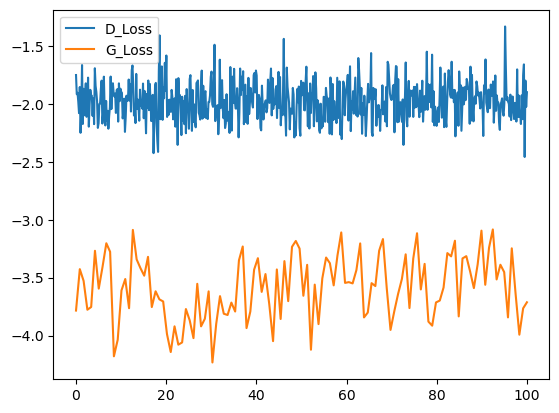

In [22]:
x_axis = np.linspace(0, 100, len(D_loss_list), endpoint=True)
x_axis1 = np.linspace(0, 100, len(G_loss_list), endpoint=True)
plt.plot(x_axis, D_loss_list, label='D_Loss')
plt.plot(x_axis1, G_loss_list, label='G_Loss')
plt.legend(loc='best')

In [14]:
len(G_loss_list)

120

## 可视化结果
可视化每次由生成器得到的假图像，即潜在向量z通过生成器得到的图像。

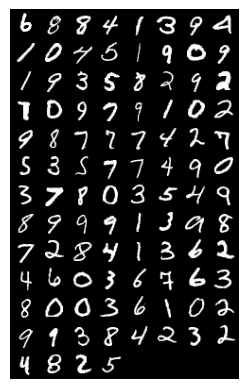

In [12]:
reconsPath = './wgangp_samples/real_images.png'
Image = imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

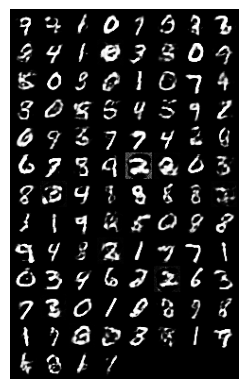

In [23]:
reconsPath = './wgangp_samples/fake_images-100.png'
Image = imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()